### Adapted from `q1.py`

In [8]:
##Script to read simulation snapshots departure time and location. Assign agent location to building.
##Global imports
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import BallTree

In [3]:
ls

README.md                   scripts/
data/                       snapshot_to_building.ipynb


### Separated start and end functions to return separate dataframes instead of a tuple

In [9]:
sim_snap = pd.read_csv("data/vehicle_data/Simulation_Snapshot/Snapshot_small.csv")

In [4]:
##Read simulation snapshot departure time.
def start_df(sim_snap_df:str,sim_start,sim_end):
    sim_snap_df = sim_snap.groupby('VEHICLE')
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    return sim_start

def end_df(sim_snap_df:str,sim_end):
    sim_snap_df = sim_snap.groupby('VEHICLE')
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    return sim_end

### Let's use a geojson vehicle snapshot instead of csv

In [5]:
sim_snap_geojson = geopandas.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
def start(sim_snap_df:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_start_gpd = sim_snap_df.head(1)
    return sim_start_gpd

def end(sim_snap_df:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

### Let's try adding condition of speed = 0 to the `end` function

In [309]:
def end_stopped(sim_snap_df:str,sim_end:str):
    sim_snap_df = sim_snap_geojson[sim_snap_geojson.SPEED  == 0].groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

### KNN using building centroids
I think we have to set a seed and use training and test data for this function - although we just want to calculate minimum euclidean distances - let's come back to this.

Regardless, the building centroids will be the dataset upon which we match the vehicle locations.

#### Additionally, 
I am not sure if k-nn is appropriate without conditioning on building types or adding some sort of weights... e.g. a huge building will be further from vehicles but likely has a lot of capacity and daytime population. I think `KNeighborsClassifier` would be most appropriate of the k-nn options in sklearn

In [311]:
sim_end=end_df(sim_snap,'3:00')
centroids=pd.read_csv('data/building_data/Building_Footprints/centroids_clipped.csv')
vehicles_coord=sim_end[['X_COORD','Y_COORD']]
centroids_coord=centroids[['xcoord','ycoord']]

In [ ]:
X_train, X_train,y_test,y_test=train_test_split(X,y,test_size=0.2, train_size=0.7,random_state=0, stratify=y)
knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean',p=2)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [222]:
neigh = NearestNeighbors(n_neighbors=2)
knn=neigh.fit(centroids_coord)

In [265]:
X = sim_end[['X_COORD','Y_COORD']]
knn_centroids=neigh.kneighbors(X, return_distance=True)
#knn_centroids=pd.DataFrame(knn_centroids[1],knn_centroids[0])
knn_dist=pd.DataFrame(knn_centroids[0])
knn_dist
knn_idx=pd.DataFrame(knn_centroids[1])
knn_centroids=[knn_idx,knn_dist]
knn_centroids

[         0     1
 0      122   493
 1     1164  1695
 2     1104   281
 3       98  1150
 4      122   493
 ...    ...   ...
 1448   705  1468
 1449  2264  1903
 1450   705  1468
 1451    51   620
 1452  1468   310
 
 [1453 rows x 2 columns],                0           1
 0     381.550754  393.770211
 1      91.620571  122.685738
 2      69.709055   70.019465
 3      37.540517   50.268252
 4     468.424436  477.682025
 ...          ...         ...
 1448  152.878803  179.593138
 1449  449.450655  466.024853
 1450  158.130126  174.067599
 1451   63.633621   85.992266
 1452  146.493136  167.859599
 
 [1453 rows x 2 columns]]

In [271]:
knn_centroids=pd.concat([knn_idx, knn_dist], axis=1)
knn_centroids.columns=['idx1','idx2','d1','d2']
knn_centroids

,idx1,idx2,d1,d2
0,122,493,381.550754,393.770211
1,1164,1695,91.620571,122.685738
2,1104,281,69.709055,70.019465
3,98,1150,37.540517,50.268252
4,122,493,468.424436,477.682025
...,...,...,...,...
1448,705,1468,152.878803,179.593138
1449,2264,1903,449.450655,466.024853
1450,705,1468,158.130126,174.067599
1451,51,620,63.633621,85.992266


## Question: 
We want to hold the attributes in the vehicles dataframe that are not used in the knn algorithm and connect them with the output. How can I connect the knn fit with the original dataset?

In [217]:
def knn_map(vehicle_id:int,end_time:str,n_neighbors:str):
    sim_snap_geojson = geopandas.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
    sim_end=end(sim_snap_geojson,end_time)
    
    centroids_coord=centroids[['xcoord','ycoord']]
    X = sim_end[['X_COORD','Y_COORD']]

    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    knn=neigh.fit(centroids_coord)
    
    knn_centroids=neigh.kneighbors(X, return_distance=True)
    
    knn_dist=pd.DataFrame(knn_centroids[0])
    knn_idx=pd.DataFrame(knn_centroids[1])
    knn_centroids=pd.concat([knn_idx, knn_dist], axis=1)
    knn_centroids=[knn_idx['idx',vehicle_id],:]
    
    return knn_centroids

In [ ]:
def count_agents(building_id:int):
    building_counts=knn_centroids['idx1',building_id].count()
    return building_counts

### adapted from `sundar_wb` branch

In [10]:
building_map=geopandas.read_file("data/building_data/Building_Footprints/buildings_clipped.geojson")

In [11]:
## Adding end df as well to see how the building occupancy changes. 
def agent_to_building(sim_start,sim_end,building_map):
    building_map = building_map.to_crs(epsg=26916)
    building_map = building_map.assign(centroid=building_map.centroid)
    
    #START
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    
    min_dist = np.empty(len(sim_start_gdf))
    for i, agent in enumerate(sim_start_gdf.geometry):
        min_dist[i] = np.argmin([agent.distance(centroid) for centroid in building_map.centroid])
    sim_start_gdf['building_id'] = min_dist
    agent_count_start = sim_start_gdf.groupby('building_id').count()
    
    #END
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    min_dist = np.empty(len(sim_end_gdf))
    for i, agent in enumerate(sim_end_gdf.geometry):
        min_dist[i] = np.argmin([agent.distance(centroid) for centroid in building_map.centroid])
    sim_end_gdf['building_id'] = min_dist
    agent_count_end = sim_end_gdf.groupby('building_id').count()

    
    build_agent_count = building_map.merge(agent_count_start.VEHICLE,right_index=True,left_index=True) 
    build_agent_count_both=build_agent_count.merge(agent_count_end.VEHICLE,right_index=True,left_index=True)
    ##ADD 1 to move building ID??
    return build_agent_count_both

In [20]:
# Generate plots, visualize start and end locations.
def plot_start_end(sim_start:str,sim_end:str,building_agent_count:str):

    building_map = build_agent_count_both.to_crs(epsg=26916)
    fig,ax = plt.subplots(figsize=(12,12))
    building_map.plot(ax=ax,column="VEHICLE_x",cmap='hot',vmin=0,vmax=50)
    minx, miny, maxx, maxy = building_map.geometry.total_bounds
    
    sim_start = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_end = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_start.crs="EPSG:26916"
    sim_end.crs="EPSG:26916"

    sim_start.plot(ax=ax, marker='o', color='lime', markersize=1,label='sim_start')
    sim_end.plot(ax=ax, marker='o', color='red', markersize=1,label='sim_end')
    
    ax.set_xlim(minx - 100, maxx + 100)
    ax.set_ylim(miny - 100, maxy + 100)
    
    sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=50))
    fig.colorbar(sm, ax=ax)
    ax.set_facecolor('xkcd:light blue')
    ax.set_title('Chicago Building Set colored by number of mapped occupants, and starting and end locations')
    ax.legend()
    
    plt.show()

In [13]:
sim_start=start(sim_snap_geojson)
sim_end=end(sim_snap_geojson)

In [14]:
build_agent_count_both=agent_to_building(sim_start,sim_end,building_map)

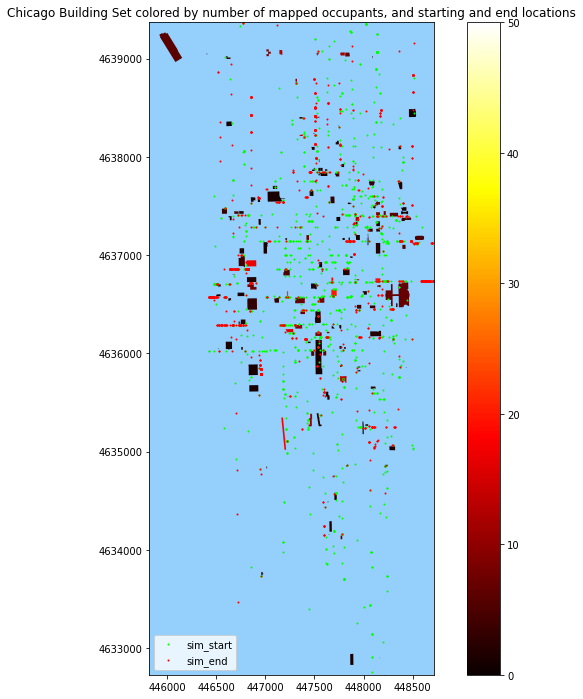

In [21]:
plot_start_end(sim_start,sim_end,build_agent_count_both)

#### TODO: Scale to 25million lines by speeding up and iterating between different sections of the snapshot.


#### From https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

In [2]:
def get_nearest(sim, building_map, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    # Create tree from the candidate points
    tree = BallTree(building_map, leaf_size=15, metric='haversine')
    # Find closest points and distances
    distances, indices = tree.query(sim, k=k_neighbors)
    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()
    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]
    # Return indices and distances
    return (closest, closest_dist)

In [ ]:
def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

## I think we should use manhattan distance instead of euclidean.

In [19]:
build_agent_count_both

,date_bldg_,time_bldg_,bldg_condi,date_bld_2,time_bld_2,date_bld_3,time_bld_3,bldg_id,bldg_name1,bldg_name2,...,unit_name,vacancy_st,x_coord,y_coord,year_built,z_coord,geometry,centroid,VEHICLE_x,VEHICLE_y
13.0,1998-04-01,08:00:00,None,1998-04-01,08:00:00,None,None,362081.0,None,None,...,None,None,1.175924e+06,1.898424e+06,0.0,0.0,"MULTIPOLYGON (((447762.268 4636248.147, 447762...",POINT (447763.845 4636271.478),1,1
50.0,1998-04-01,08:00:00,None,1998-04-01,08:00:00,None,None,352202.0,HYATT REGENCY HOTEL,None,...,REAR,None,1.178011e+06,1.902272e+06,1980.0,0.0,"MULTIPOLYGON (((448382.247 4637416.715, 448382...",POINT (448417.826 4637432.017),1,4
83.0,1998-04-01,08:00:00,None,1998-04-01,08:00:00,None,None,378330.0,None,None,...,None,None,1.175653e+06,1.891473e+06,0.0,0.0,"MULTIPOLYGON (((447641.662 4634153.086, 447641...",POINT (447648.097 4634154.885),1,3
85.0,1998-04-01,08:00:00,NEEDS MINOR REPAIR,1998-04-01,08:00:00,None,None,373810.0,None,None,...,None,None,1.177535e+06,1.893819e+06,0.0,0.0,"MULTIPOLYGON (((448221.893 4634852.397, 448219...",POINT (448232.600 4634859.981),5,1
121.0,1998-04-01,08:00:00,None,1998-04-01,08:00:00,None,None,353106.0,None,None,...,None,None,1.174597e+06,1.901745e+06,0.0,0.0,"MULTIPOLYGON (((447370.087 4637287.244, 447370...",POINT (447375.190 4637289.259),6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7418.0,1998-04-01,08:00:00,SOUND,1998-04-01,08:00:00,None,None,350045.0,UNIVERSITY OF CHICAGO GLEACHER CENTER,None,...,None,None,1.177860e+06,1.903186e+06,1996.0,0.0,"MULTIPOLYGON (((448387.231 4637668.794, 448369...",POINT (448376.350 4637710.470),2,2
7461.0,2005-05-25,07:00:00,SOUND,2005-05-25,07:00:00,None,None,824885.0,ABN Amro Plaza,None,...,None,None,1.172602e+06,1.900567e+06,2003.0,0.0,"MULTIPOLYGON (((446729.170 4636971.669, 446750...",POINT (446762.961 4636935.981),4,3
7558.0,2005-05-25,07:00:00,SOUND,2005-05-25,07:00:00,None,None,824983.0,THE LOFTS AT MUSEUM PARK I,None,...,None,None,1.177721e+06,1.894394e+06,2004.0,0.0,"MULTIPOLYGON (((448262.560 4635055.592, 448321...",POINT (448292.344 4635035.555),1,2
7570.0,2008-01-09,08:00:00,SOUND,2008-01-09,08:00:00,None,None,874129.0,None,None,...,None,N,1.177681e+06,1.897961e+06,2007.0,0.0,"MULTIPOLYGON (((448299.937 4636119.798, 448294...",POINT (448296.819 4636122.144),9,1


In [23]:
building_map

,date_bldg_,time_bldg_,bldg_condi,date_bld_2,time_bld_2,date_bld_3,time_bld_3,bldg_id,bldg_name1,bldg_name2,...,stories,suf_dir1,t_add1,unit_name,vacancy_st,x_coord,y_coord,year_built,z_coord,geometry
0,2014-07-30,07:00:00,SOUND,2014-07-30,07:00:00,None,None,893534.0,GOODMAN CENTER FOR ROOSEVELT UNIVERSITY,None,...,2.0,None,501.0,None,None,1.176983e+06,1.897976e+06,2012.0,0.0,"MULTIPOLYGON (((-87.62547 41.87519, -87.62581 ..."
1,2002-12-20,08:00:00,None,2002-12-20,08:00:00,None,None,814782.0,None,None,...,8.0,None,600.0,None,None,1.172255e+06,1.899044e+06,1912.0,0.0,"MULTIPOLYGON (((-87.64303 41.87850, -87.64270 ..."
2,2005-01-07,08:00:00,None,2005-01-07,08:00:00,None,None,823138.0,None,None,...,0.0,None,1912.0,None,None,1.174601e+06,1.890798e+06,0.0,0.0,"MULTIPOLYGON (((-87.63470 41.85575, -87.63456 ..."
3,1998-04-01,08:00:00,NEEDS MINOR REPAIR,1998-04-01,08:00:00,None,None,377598.0,None,None,...,3.0,None,1004.0,None,None,1.169912e+06,1.891660e+06,1889.0,0.0,"MULTIPOLYGON (((-87.65184 41.85812, -87.65184 ..."
4,1998-04-01,08:00:00,SOUND,1998-04-01,08:00:00,None,None,390646.0,None,None,...,1.0,None,2425.0,None,None,1.172748e+06,1.888255e+06,1915.0,0.0,"MULTIPOLYGON (((-87.64152 41.84825, -87.64207 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,2010-06-23,07:00:00,SOUND,2007-03-29,07:00:00,None,None,847025.0,None,None,...,5.0,None,167.0,None,None,1.177655e+06,1.904150e+06,2007.0,0.0,"MULTIPOLYGON (((-87.62318 41.89244, -87.62282 ..."
7689,1998-04-01,08:00:00,None,1998-04-01,08:00:00,None,None,340705.0,None,None,...,0.0,None,531.0,None,None,1.172351e+06,1.905183e+06,0.0,0.0,"MULTIPOLYGON (((-87.64273 41.89511, -87.64275 ..."
7690,None,None,SOUND,2009-09-29,07:00:00,None,None,888280.0,ALTA/CIRRUS,None,...,37.0,None,555.0,None,None,1.172536e+06,1.902826e+06,2009.0,0.0,"MULTIPOLYGON (((-87.64165 41.88868, -87.64200 ..."
7691,1998-04-01,08:00:00,SOUND,1998-04-01,08:00:00,None,None,367341.0,EAST-WEST UNIVERSITY,None,...,8.0,None,819.0,None,None,1.177046e+06,1.896500e+06,1912.0,0.0,"MULTIPOLYGON (((-87.62519 41.87145, -87.62518 ..."


In [24]:
building_agent_count_both=

NameError: name 'building_agent_count_both' is not defined